**19. Making training GPU compatible in Pytorch**

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
import torch as tr
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# set random seeds for reproducibility
random_seed = 14

**`1. Check GPU availability`**

In [5]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [6]:
df = pd.read_csv('datasets/fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


*Data preprocessing and DataLoader creation*

**`4. Other data improvements for GPU`**

* increase the batch size
* set `pin_memory = True` in DataLoader 

In [7]:
# getting data as numpy arrays
X = df.drop(columns=['label']).to_numpy()
y = df['label'].to_numpy()

class_labels =  ["T-shirt/top",
                "Trouser",
                "Pullover",
                "Dress",
                "Coat",
                "Sandal",
                "Shirt",
                "Sneaker",
                "Bag",
                "Ankle boot"]

# perform train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# convert the arrays into pytorch tensors
X_train_tensor = tr.tensor(X_train, dtype= tr.float32)
X_test_tensor = tr.tensor(X_test, dtype= tr.float32) 
y_train_tensor = tr.tensor(y_train, dtype= tr.long) 
y_test_tensor = tr.tensor(y_test, dtype= tr.long) 

# creating dataset class
class FMNIST_DATASET(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.normalize(self.X[index]),self.y[index]

    def normalize(self,X):
        return (X/255.0).astype(np.float32)
    
train_dataset = FMNIST_DATASET(X_train,y_train)
test_dataset = FMNIST_DATASET(X_test,y_test)


BATCH_SIZE = 32
train_loader = DataLoader(train_dataset,batch_size= BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset,batch_size= BATCH_SIZE, shuffle = False)

*Image Visualization*

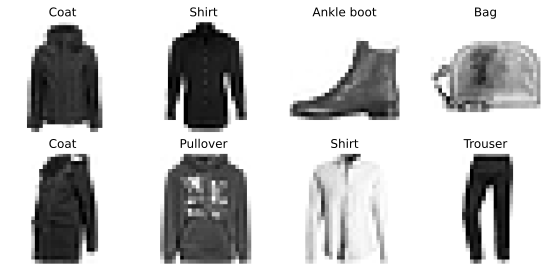

In [8]:
fig,axes = plt.subplots(2,4,figsize = (8,4))

images,labels = next(iter(train_loader))


for i,ax in enumerate(axes.flat):
    img = images[i].reshape(28,28)
    ax.imshow(img,cmap = 'binary')
    ax.axis('off')
    ax.set_title(f'{class_labels[labels[i]]}')

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

*Neural Network Creation*

**Notes:**
* PyTorch's CrossEntropyLoss has internal implementation of softmax, hence no explict need to add softmax.
* `optimizer.grad.zero_()`, optimizer doesn't have a attribute `.grad`, hence we do `optimizer.zero_grad()`

*Tackling overfitting*
1. Dropout:
     * Applied to hidden layers:
     * Applied after the ReLU activation function (usually after activation function).
     * Randomly turns off p% neurons in the hidden layer during each forward pass.
     * Not used during evaluation.

2. Batch Normalization
     * Applied to hidden layers:
       * Typically applied to hidden layers of neural network, but not to the output layer.
     * Applied after Linear layers before activation functions:
       * Normalizes the output of the preceding layer (eg: after nn.Linear) and is usually followed by an activation function (eg: ReLU).
     * Normalizes Activation:
       * Computes the mean and variance of the activation within a mini-batch and uses these statistics to normalize the activations.
     * Includes learnable parameters:
       * Introduces two learnable parameters, gamma(scaling) and beta(shifting), which allows the network to adjust to the normalized outputs.
     * Improves training stability:
       * Reduces internal covariate shift, stabilizing the training process and allowing the use of higher learning rate.
     * Regularization Effect:
       * Introduces some regularization because the statistics are computed over a mini-batch, adding noise to the training process.
     * Consistent during evaluation:
       * During evaluation, BatchNorm uses the running mean and variance accumulated during training, rather than recomputing them from the mini-batch.
  
3. L2 Regularization
   * Applied to model weights:
     * Regularization is applied to the weights of the model to penalize large values and encourage smaller, more generalizable weights.
   * Introduced via Function or Optimizer:
     * Adds a penalty term $\lambda \sum_{i} w_i^2$ to the loss function<br>
        $$
        Loss_{reg} = Loss_{original} + \lambda \sum_{i} w_i^2
        $$
     * In `weight decay`, directly modifies the gradient update rule to include $\lambda w_{i}$, effectively shrinking weights during training.
        $$
          w \rightarrow w - \eta(\nabla Loss + \lambda w)
        $$
   * Penalizes large weights:
     * Encourages the network to distribute learning across multiple parameters, avoiding relience on a few large weights.
   * Reduces overfitting:
     * Helps model generalize better to unseen data by discouraging overly complex representations.
   * Controlled by a hyperparameter:
     * A regularization coefficient ($\lambda$, often set via `weight_decay` in optimizers) controls the strength of the penalty. Larger values lead to stronger regularization.
   * No effect on Bias Term:
     * Regularization is typically applied only to weights, not biases, as biases don't directly affect the model complexity.
   * Active during training:
     * Regularization affects weight updates only during training. It does not explicitly influence the model during inference.

In [38]:
class FMNIST_NET(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(in_features=784,out_features=64)
        self.batchnorm1 = nn.BatchNorm1d(num_features=64) # no of activations from prev layer
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p = 0.3)
        self.linear2 = nn.Linear(in_features=64,out_features=32)
        self.batchnorm2 = nn.BatchNorm1d(num_features=32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p = 0.3)
        self.linear3 = nn.Linear(in_features=32,out_features=10)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        return x

# from torchinfo import summary
# demo_model = FMNIST_NET()
# summary(demo_model)

In [39]:
# learning rate and epochs
lr = 1e-3
epochs = 100

# instantiating the model
fnet = FMNIST_NET()

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = tr.optim.Adam(fnet.parameters(), lr = lr, weight_decay=1e-4)

**`2. Move the model to GPU`**

In [40]:
fnet = fnet.to(device) # move the model to GPU

**`3. Modify the training loop by moving data to GPU`**

In [41]:
# training loop
for epochi in range(epochs):
    fnet.train()
    batch_loss = []
    for X_batch,y_batch in train_loader:
        # moving data to device (GPU)
        X_batch,y_batch = X_batch.to(device),y_batch.to(device)
        
        # forward pass
        y_pred = fnet(X_batch)

        # loss calculation
        loss = loss_fn(y_pred,y_batch)
        batch_loss.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # upgrade parameters
        optimizer.step()

    mean_batch_loss = np.mean(batch_loss)
    
    # perform validation
    fnet.eval()
    val_correct = 0
    val_total = 0

    with tr.no_grad(): # disable gradient tracking
        for X_val,y_val in test_loader:
            # moving data to device(GPU)
            X_val,y_val = X_val.to(device),y_val.to(device)
            
            y_pred = fnet(X_val)
            preds = tr.argmax(y_pred,dim=1)
            val_correct += (preds == y_val).sum().item()
            val_total += y_val.size(0)
    val_acc = (val_correct / val_total)*100

    print(f'Epoch: {epochi+1}, Loss: {mean_batch_loss}, Val Accuracy:{val_acc:.2f}%')

Epoch: 1, Loss: 1.413282914161682, Val Accuracy:78.33%
Epoch: 2, Loss: 0.9162381780147553, Val Accuracy:77.92%
Epoch: 3, Loss: 0.7532879543304444, Val Accuracy:79.83%
Epoch: 4, Loss: 0.6907986636956532, Val Accuracy:81.00%
Epoch: 5, Loss: 0.6485056595007579, Val Accuracy:82.00%
Epoch: 6, Loss: 0.5964321253697077, Val Accuracy:83.42%
Epoch: 7, Loss: 0.5782706371943156, Val Accuracy:83.08%
Epoch: 8, Loss: 0.5533741943041484, Val Accuracy:83.42%
Epoch: 9, Loss: 0.5341137067476909, Val Accuracy:82.92%
Epoch: 10, Loss: 0.5109282715121904, Val Accuracy:84.08%
Epoch: 11, Loss: 0.5043077831466992, Val Accuracy:83.50%
Epoch: 12, Loss: 0.4744074889520804, Val Accuracy:83.50%
Epoch: 13, Loss: 0.4726171683271726, Val Accuracy:83.25%
Epoch: 14, Loss: 0.46264374603827796, Val Accuracy:84.25%
Epoch: 15, Loss: 0.46895261799295745, Val Accuracy:84.92%
Epoch: 16, Loss: 0.4475348755717278, Val Accuracy:84.75%
Epoch: 17, Loss: 0.4378750906387965, Val Accuracy:84.58%
Epoch: 18, Loss: 0.4138699769973755, Va

In [42]:
# check the training accuracy
train_correct = 0
train_total = 0

with tr.no_grad(): # disable gradient tracking
    for X_batch,y_batch in train_loader:
        # moving data to device(GPU)
        X_batch,y_batch = X_batch.to(device),y_batch.to(device)
        
        y_pred = fnet(X_batch)
        preds = tr.argmax(y_pred,dim=1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.size(0)
train_acc = (train_correct / train_total)*100
print(train_acc)

# we observe that the model is overfitting

96.8125


**Notes:**
* In TensorFlow, we don't need to manually place the model on the GPU. TensorFlow automatically places the model on the GPU if one is available and visible.
* In TensorFlow, we don't need to manually move the data to GPU. As long as the data is a tf.Tensor or tf.data.Dataset, TensorFlow will automatically handle the device placement.
* Even though you write your custom training function, you don't need to manually handle GPU placement for:
  * model
  * data
  * or computations

`Solutions to overfitting:`
* Adding more data (we can use 70k dataset)
* Reducing the complexity of Neural Network (Model used is already simple)
* Regularization (L2 regularization usually used in DL) ✔️
* Dropouts ✔️
* Data Augmentation (Usually used in CNNs)
* Batch Normalization (Usually used to stabilize training, side-outcome: regularization effect) ✔️
* Early Stopping (will cover later)